In [5]:
from pychunkedgraph.graph import ChunkedGraph, attributes
import numpy as np
import collections
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates

In [14]:
dataset = "h01_full0_v2"
# dataset = "fish1_v250117"
cg = ChunkedGraph(graph_id=dataset)

### Get all operations

In [15]:
max_op_id = cg.client.get_max_operation_id()
max_op_id

31745

In [16]:
max_op_id = cg.client.get_max_operation_id()
log_rows = {}
num_sections = max(1, max_op_id // 100000)
for id_batch in np.array_split(np.arange(0, max_op_id), num_sections):
    %time log_rows.update(cg.client.read_log_entries(operation_ids=id_batch))

CPU times: user 3.69 s, sys: 595 ms, total: 4.28 s
Wall time: 9.91 s


In [17]:
for id_batch in np.array_split(np.arange(0, max_op_id), num_sections):
    print(id_batch)

[    0     1     2 ... 31742 31743 31744]


In [18]:
log_data = collections.defaultdict(list)

for operation_id, log_row in log_rows.items():
    if log_row.get(attributes.OperationLogs.Status, 0) != 0:
        continue
        
    log_data["date"].append(log_row["timestamp"])
    log_data["timestamp"].append(log_row["timestamp"].timestamp())
    log_data["user_id"].append(log_row[attributes.OperationLogs.UserID])
    
    if log_row[attributes.OperationLogs.SinkCoordinate][0][0] > 1e9:
        sinks = np.frombuffer(log_row[attributes.OperationLogs.SinkCoordinate]).reshape(-1, 3)
        sources = np.frombuffer(log_row[attributes.OperationLogs.SourceCoordinate]).reshape(-1, 3)
    else:
        sinks = log_row[attributes.OperationLogs.SinkCoordinate]
        sources = log_row[attributes.OperationLogs.SourceCoordinate]
    mean_coord = (np.mean(sinks, axis=0) + np.mean(sources, axis=0)) / 2
    log_data["coord_x"].append(mean_coord[0])
    log_data["coord_y"].append(mean_coord[1])
    log_data["coord_z"].append(mean_coord[2])
    log_data["operation_id"].append(operation_id)

### Plot results

/tmp/ipykernel_5466/4196357290.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


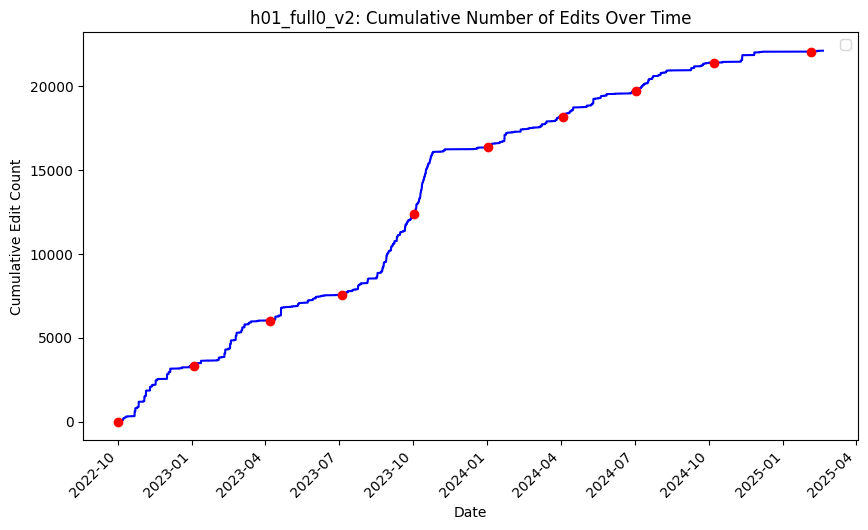

In [19]:
# Sort the dates to ensure the cumulative sum is calculated in order
# dates = sorted(log_data['date'])
dates = [d.replace(tzinfo=None) for d in sorted(log_data['date'])]

# Initialize cumulative count
cumulative_counts = []
cumulative_sum = 0

# Calculate cumulative sum of edits over time
for _ in dates:
    cumulative_sum += 1
    cumulative_counts.append(cumulative_sum)

def add_months(source_date, months):
    # Calculate the new month and year considering year overflow
    month = source_date.month - 1 + months
    year = source_date.year + month // 12
    month = month % 12 + 1
    day = min(source_date.day, [31, 29 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month - 1])
    return datetime(year, month, day, source_date.hour, source_date.minute, source_date.second, source_date.microsecond)

range_dates = []
range_counts = []

next_marker_date = dates[0]  # Start from the first date
# print(dates, next_marker_date)
for i, date in enumerate(dates):
    if date >= next_marker_date:  # If current date is on or after the next marker date
        range_dates.append(date)
        range_counts.append(cumulative_counts[i])
        next_marker_date = add_months(next_marker_date, 3)

# Plot the line for all data
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_counts, linestyle='-', color='b')

# Add circle markers at exact intervals
plt.plot(range_dates, range_counts, marker='o', linestyle='None', color='r')

# Formatting the date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the x-axis labels as Year-Month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set the locator to intervals

plt.gcf().autofmt_xdate()  # Auto format the x-axis for better readability
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Cumulative Edit Count')
plt.title('{}: Cumulative Number of Edits Over Time'.format(dataset))
# plt.grid(True)
plt.legend()
plt.show()